# Class Activation Map을 이용한 CNN visualization

* Identify important image regions by projecting back the weights of output layer to convolutional feature maps. 
* CAMs can be generated for each class in single image.
* Regions for each categories are different in given image.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

## Data 준비하기

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/seg_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/seg_val.tfr'

# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        class_list.append(line)

In [4]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Classification

### 37개 Class로 classification 하기

In [5]:
IMG_SIZE = 224
N_CLASS = len(class_list)

N_EPOCHS = 20
N_BATCH = 60

learning_rate = 0.0001

N_TRAIN = 6000
N_VAL = 1378
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'seg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [7]:
## train dataset
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [8]:
## validation dataset
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

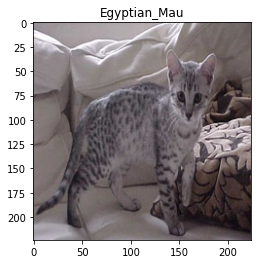

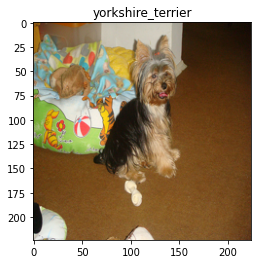

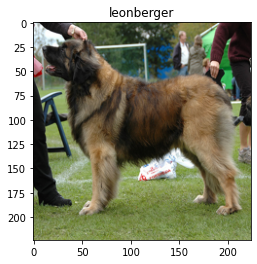

In [9]:
for images, labels in train_dataset.take(3):
    plt.imshow(images[0])
    title = class_list[labels[0].numpy()]
    plt.title(title)
    plt.show()

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [11]:
def create_mv_model():
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)
    output = Dense(N_CLASS, activation='softmax', name='output_layer')(gap)
    return keras.Model(inputs=mobilenetv2.input, outputs=output)  

In [12]:
model1 = create_mv_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model1.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model1.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
100/100 [==============================] - 61s 458ms/step - loss: 1.3106 - accuracy: 0.6853 - val_loss: 0.7244 - val_accuracy: 0.7692
Epoch 2/20
100/100 [==============================] - 44s 407ms/step - loss: 0.2477 - accuracy: 0.9372 - val_loss: 0.5552 - val_accuracy: 0.8186
Epoch 3/20
100/100 [==============================] - 44s 410ms/step - loss: 0.1077 - accuracy: 0.9802 - val_loss: 0.4766 - val_accuracy: 0.8462
Epoch 4/20
100/100 [==============================] - 44s 407ms/step - loss: 0.0531 - accuracy: 0.9948 - val_loss: 0.4127 - val_accuracy: 0.8657
Epoch 5/20
100/100 [==============================] - 44s 405ms/step - loss: 0.0291 - accuracy: 0.9983 - val_loss: 0.3785 - val_accuracy: 0.8774
Epoch 6/20
100/100 [==============================] - 44s 407ms/step - loss: 0.0187 - accuracy: 0.9990 - val_loss: 0.3430 - val_accuracy: 0.8926
Epoch 7/20
100/100 [==============================] - 44s 407ms/step - loss: 0.0143 - accuracy: 0.9997 - val_loss: 0.3416 - val_ac

### Class Activation Map 만들기

In [14]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
target_fmap = model1.get_layer(name='out_relu').output   # global average pool 바로 전 ReLU layer. shape : (7, 7, 1280)

new_model1 = keras.models.Model(model1.input, target_fmap)  # 각 이미지에 대해 out_relu layer의 feature map을 반환

weights = model1.get_layer(name='output_layer').get_weights()[0]

In [16]:
weights.shape

(1280, 37)

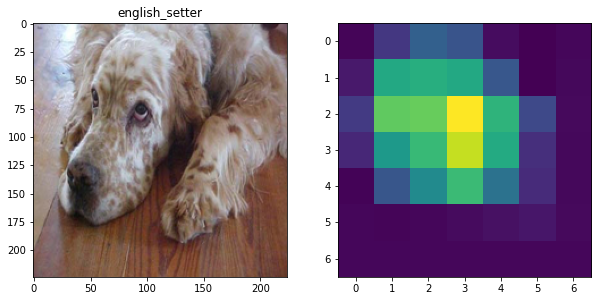

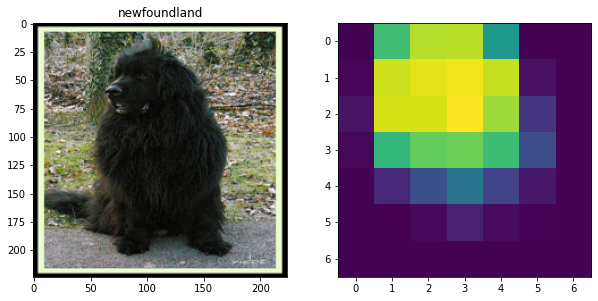

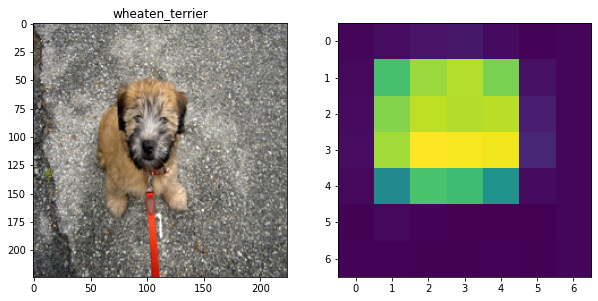

In [17]:
for images, labels in val_dataset.take(3):
    plt.figure(figsize=(10,6))

    # 이미지
    plt.subplot(1,2,1)
    plt.imshow(images[0])
    prediction = model1.predict(images)
    pred_class = np.argmax(prediction[0], -1)
    title = class_list[pred_class]
    plt.title(title)

    # class activation map
    plt.subplot(1,2,2)
    fmap = new_model1(images)
    weights_cam = weights[:,pred_class]
    camsum = np.zeros((7,7))
    for i in range(1280):
        camsum += weights_cam[i]*fmap[0,:,:,i]
    camsum = camsum / 1280
    plt.imshow(camsum)

    plt.show()

### 고양이/개 2 Class로 classification 하기

In [18]:
N_CLASS = 2

In [19]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'seg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, bi_cls_label

In [20]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [21]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

tf.Tensor(1, shape=(), dtype=int64)


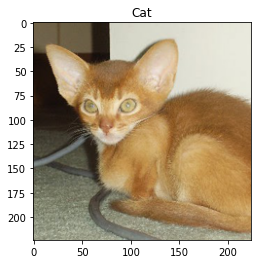

tf.Tensor(0, shape=(), dtype=int64)


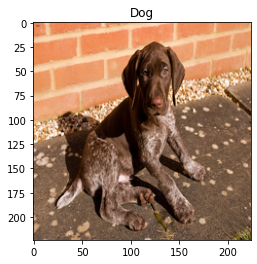

tf.Tensor(0, shape=(), dtype=int64)


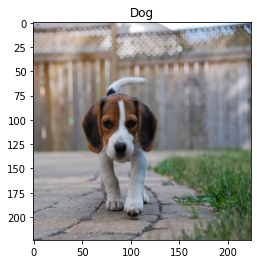

In [22]:
for images, labels in train_dataset.take(3):
    plt.imshow(images[0])
    print(labels[0])
    if labels[0] == 0:
        title = 'Dog'
    else:
        title = 'Cat'
    plt.title(title)
    plt.show()

In [23]:
def create_mv_model():
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)
    output = Dense(N_CLASS, activation='softmax', name='output_layer')(gap)
    return keras.Model(inputs=mobilenetv2.input, outputs=output)  

In [24]:
model2 = create_mv_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model2.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
history = model2.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
100/100 [==============================] - 48s 412ms/step - loss: 0.0749 - accuracy: 0.9713 - val_loss: 0.0361 - val_accuracy: 0.9869
Epoch 2/20
100/100 [==============================] - 44s 404ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.0180 - val_accuracy: 0.9942
Epoch 3/20
100/100 [==============================] - 44s 404ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0164 - val_accuracy: 0.9942
Epoch 4/20
100/100 [==============================] - 43s 399ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9964
Epoch 5/20
100/100 [==============================] - 44s 404ms/step - loss: 9.7266e-04 - accuracy: 0.9998 - val_loss: 0.0153 - val_accuracy: 0.9949
Epoch 6/20
100/100 [==============================] - 44s 405ms/step - loss: 6.8729e-04 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9942
Epoch 7/20
100/100 [==============================] - 44s 402ms/step - loss: 3.1232e-04 - accuracy: 1.0000 - val_loss: 0.0

### Class Activation Map 만들기

In [26]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [27]:
target_fmap = model2.get_layer(name='out_relu').output
new_model2 = keras.models.Model(model2.input, target_fmap)

weights = model2.get_layer(name='output_layer').get_weights()[0]

In [28]:
weights.shape

(1280, 2)

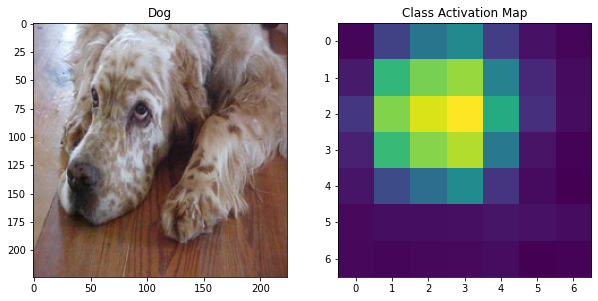

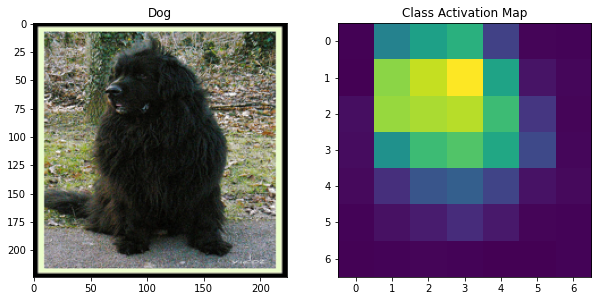

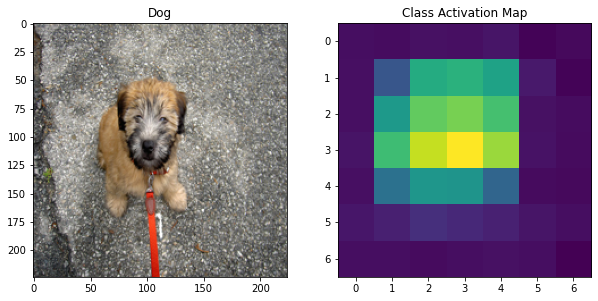

In [29]:
for images, labels in val_dataset.take(3):
    plt.figure(figsize=(10,6))

    plt.subplot(1,2,1)
    plt.imshow(images[0])
    prediction = model2.predict(images)
    pred_class = np.argmax(prediction[0], -1)
    if labels[0] == 0:
        title = 'Dog'
    else:
        title = 'Cat'
    plt.title(title)

    plt.subplot(1,2,2)
    fmap = new_model2(images)
    weights_cam = weights[:,pred_class]
    camsum = np.zeros((7,7))
    for i in range(1280):
        camsum += weights_cam[i]*fmap[0,:,:,i]
    camsum = camsum / 1280
    plt.title('Class Activation Map')
    plt.imshow(camsum)

    plt.show()

### 2개 model의 CAM 비교하기

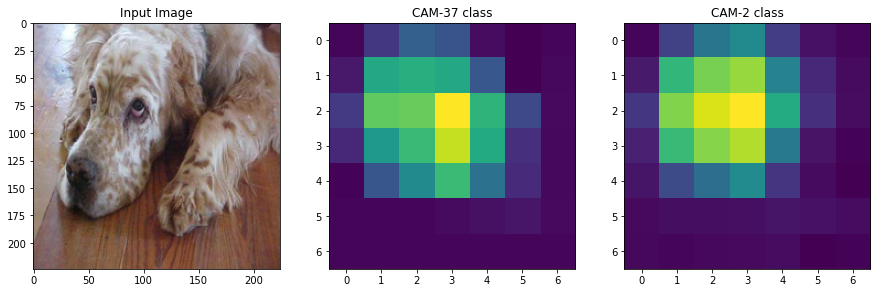

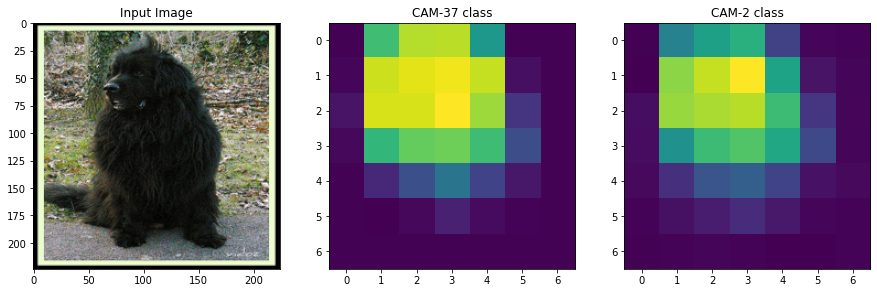

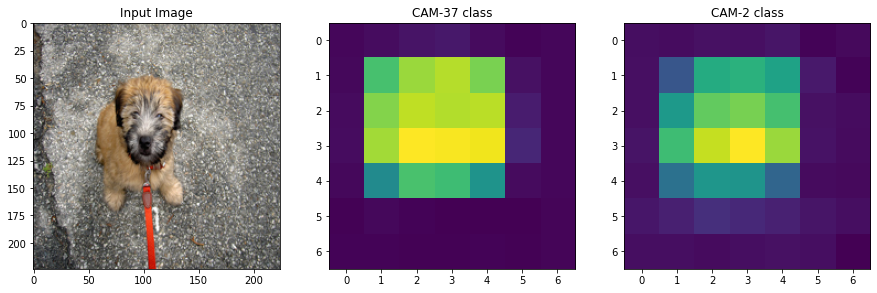

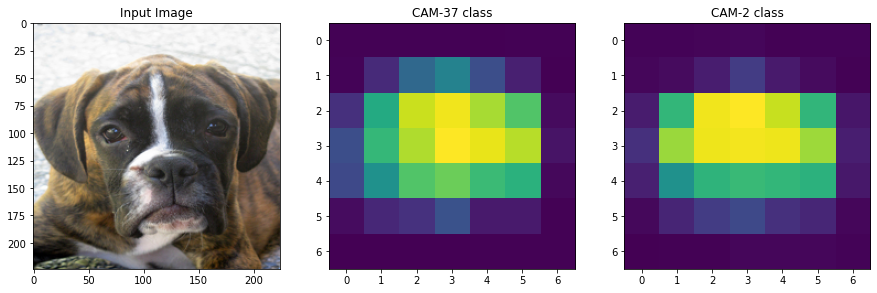

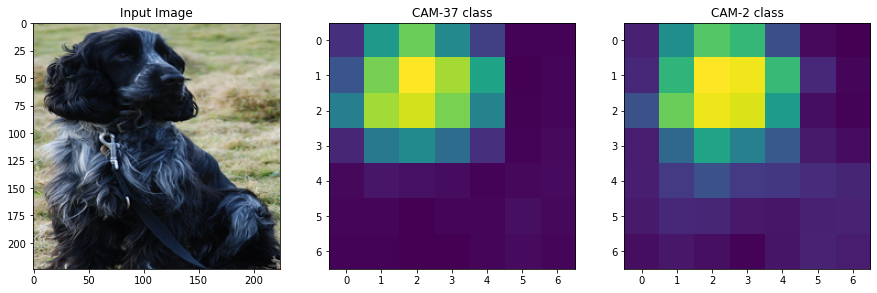

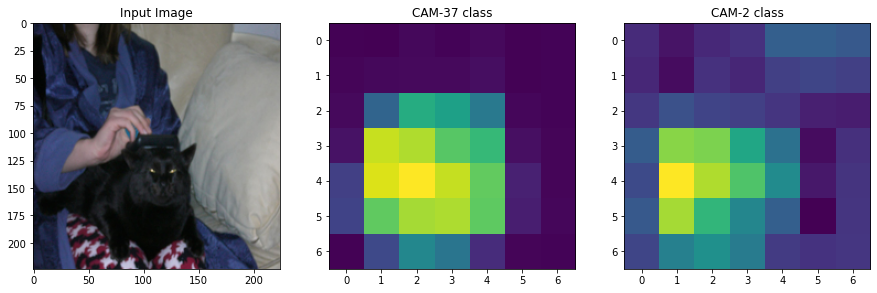

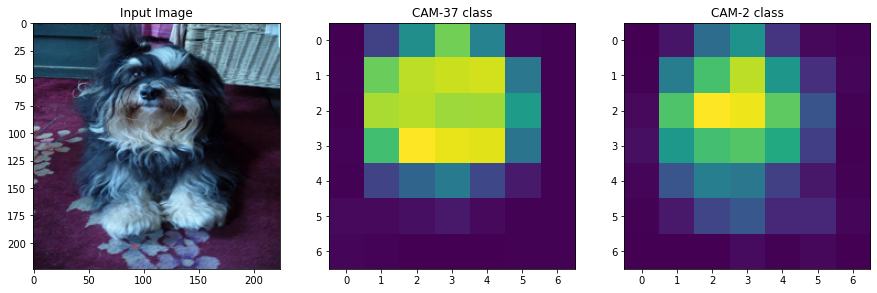

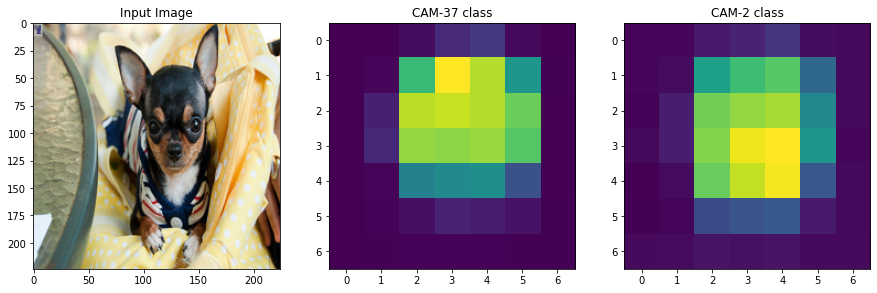

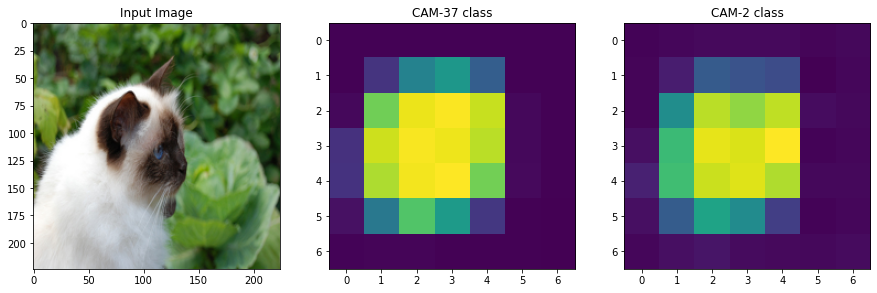

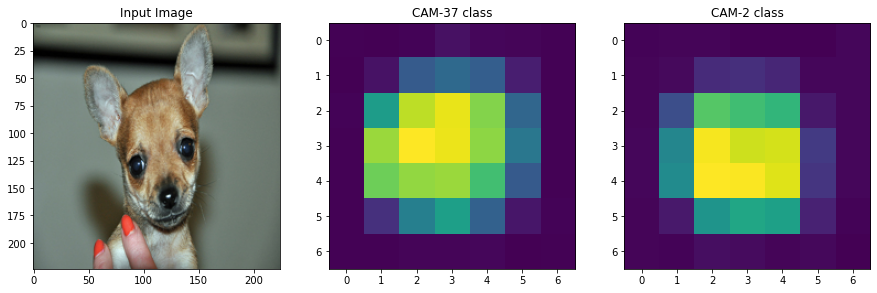

In [30]:
for images, labels in val_dataset.take(10):
    plt.figure(figsize=(15,6))

    plt.subplot(1,3,1)
    plt.imshow(images[0])    
    plt.title('Input Image')

    plt.subplot(1,3,2)
    prediction1 = model1.predict(images)
    pred_class1 = np.argmax(prediction1[0], -1)
    fmap1 = new_model1(images)
    weights1 = model1.get_layer(name='output_layer').get_weights()[0]
    weights_cam1 = weights1[:,pred_class1]
    camsum1 = np.zeros((7,7))
    for i in range(1280):
        camsum1 += weights_cam1[i]*fmap1[0,:,:,i]
    camsum1 = camsum1 / 1280
    plt.title('CAM-37 class')
    plt.imshow(camsum1)

    plt.subplot(1,3,3)
    prediction2 = model2.predict(images)
    pred_class2 = np.argmax(prediction2[0], -1)
    fmap2 = new_model2(images)
    weights2 = model2.get_layer(name='output_layer').get_weights()[0]
    weights_cam2 = weights2[:,pred_class2]
    camsum2 = np.zeros((7,7))
    for i in range(1280):
        camsum2 += weights_cam2[i]*fmap2[0,:,:,i]
    camsum2 = camsum2 / 1280
    plt.title('CAM-2 class')
    plt.imshow(camsum2)

    plt.show()